## Uses the emergent embeddings for the Advection-Diffusion dataset found in 
## Diffusion_Convection/1_80_100/ForNN
## and creates a Hidden Physics model. 

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim
from pyDOE import lhs

import os
import sys

from collections import OrderedDict

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

from DenseNN import DenseNN

torch.manual_seed(1234)
np.random.seed(1234)


plt.rc('text', usetex=False); 
plt.rc('font', family='serif');
plt.rc('font', family='serif');

In [2]:
DATA_PATH = '../Diffusion_Convection/1_80_100/ForNN/'

U_or = np.load(f"{DATA_PATH}U.npy")
x_emb = np.load(f"{DATA_PATH}x_evec.npy")
t_emb = np.load(f"{DATA_PATH}t_evec.npy")

# CUDA support 
if torch.backends.mps.is_built():
    device = torch.device('mps')
elif torch.cude.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Reorganize data using emergent embeddings before building model.

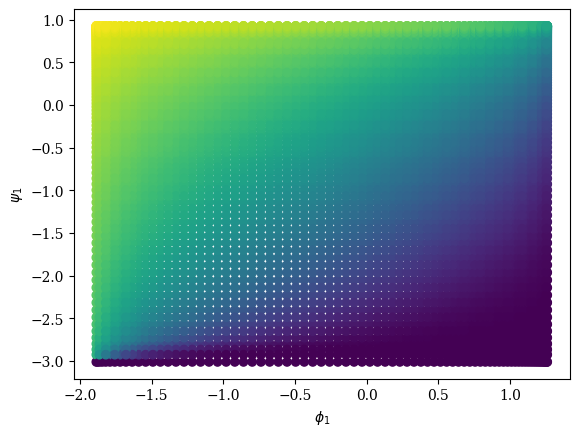

In [3]:
x = np.zeros(len(x_emb)*len(t_emb))
t = np.zeros(len(x_emb)*len(t_emb))
U = np.zeros(len(x_emb)*len(t_emb))

count = 0
for i, x_ev in enumerate(x_emb):
    for j, t_ev in enumerate(t_emb):
        U[count] = U_or[i, j]
        x[count] = x_ev
        t[count] = t_ev
        count +=1

X = np.array(np.vstack((x, t)).T)

# plot to make sure it's the same
plt.scatter(x, t, c=U)
plt.xlabel(r"$\phi_1$")
plt.ylabel(r"$\psi_1$")
plt.show()


In [4]:
N = 100

phi_wholespace = np.linspace(min(x), max(x), N)
psi_wholespace = np.linspace(min(t), max(t), N)
phi_W, psi_W = np.meshgrid(phi_wholespace, psi_wholespace)
allpoints = np.hstack((phi_W.flatten()[:,None], psi_W.flatten()[:,None]))

Build emergent model (Hidden Physics).

8000


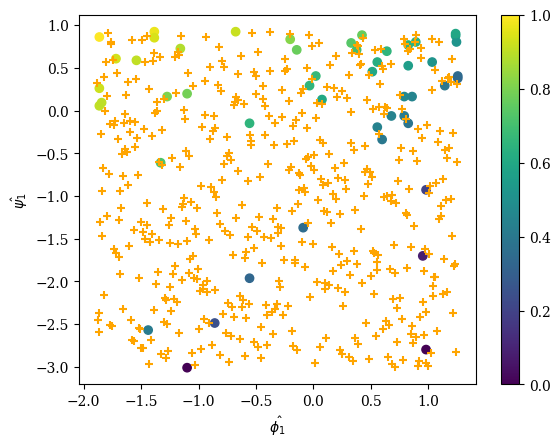

In [5]:
class PlainNN():
    """
    Hidden Physics Model for Advection-Diffusion equation.
    Maintain same colocation points, and calculates derivatives to be used in physics informed loss.
    """

    # X, U, lb, ub are all tensors
    def __init__(self, layers, X, U, lb, ub):

        self.ub = ub
        self.lb = lb
    
        self.dnn = DenseNN(layers)
        self.dnn2 = DenseNN(layers)        
        
        # data points
        self.x = X[:, 0:1]
        self.t = X[:, 1:2]
        self.U = U

        # colocation points
        np.random.seed(1234)
        colocation_points = lhs(n=2, samples=500)*(ub.clone().detach().cpu().numpy()-lb.clone().detach().cpu().numpy())+lb.clone().detach().cpu().numpy()
        self.x_c = torch.from_numpy(colocation_points[:,0:1]).float()
        self.t_c = torch.from_numpy(colocation_points[:,1:2]).float()

        self.dnnparams = []
        self.dnnparams.extend(self.dnn.parameters())
        self.dnnparams.extend(self.dnn2.parameters())
        
        self.optimizer = torch.optim.Adam(self.dnnparams, lr=0.001)
        
        self.iter = 0

        self.losslist = []
        self.phy_loss = []
        self.data_loss = []

    def set_learning_rate(self, lr):
        self.optimizer.param_groups[0]['lr'] = lr

    # X is a tensor
    def scale_input(self, X):
        return 2*(X-self.lb)/(self.ub-self.lb) - 1
    
    # z is a numpy array
    def scale_input_numpy(self, z, index): # z is a numpy array
        lb = self.lb[index].detach().cpu().numpy()
        ub = self.ub[index].detach().cpu().numpy()
        return 2*(z - lb) / (ub - lb) - 1
    
    def plot_scaled_input(self):
        plt.scatter(self.scale_input_numpy(self.x.clone().detach().cpu().numpy(), 0),
                    self.scale_input_numpy(self.t.clone().detach().cpu().numpy(), 1), 
                    c=self.U.clone().detach().cpu().numpy())
        plt.xlabel(r"$\hat{\phi_1}$")
        plt.ylabel(r"$\hat{\psi_1}$")
        plt.colorbar()
        plt.show()

    def plot_input(self):
        plt.scatter(self.x.clone().detach().cpu().numpy(),
                    self.t.clone().detach().cpu().numpy(),
                    c=self.U.clone().detach().cpu().numpy())
        plt.scatter(self.x_c.clone().detach().cpu().numpy(),
                    self.t_c.clone().detach().cpu().numpy(),
                    color = "orange", marker="+")
        plt.xlabel(r"$\hat{\phi_1}$")
        plt.ylabel(r"$\hat{\psi_1}$")
        plt.colorbar()
        plt.show()
    

    def net_C(self, x, t):
        return self.dnn(torch.cat([x,t], dim=1))*(t-self.lb[1]) # forces initial condition to be 0 

    def net_N(self, c_x, c_xx):
        return self.dnn2(torch.cat([c_x, c_xx], dim=1))

    
    def get_derivatives(self, x, t):

        x.requires_grad_(True)
        t.requires_grad_(True)
    
        c = self.net_C(x, t)
        
        c_t = torch.autograd.grad(
            c, t, 
            grad_outputs=torch.ones_like(c),
            #retain_graph=True,
            create_graph=True
        )[0]

        c_x = torch.autograd.grad(
            c, x, 
            grad_outputs=torch.ones_like(c),
            retain_graph=True,
            create_graph=True
        )[0]

        c_xx = torch.autograd.grad(
            c_x, x, 
            grad_outputs=torch.ones_like(c_x),
            #retain_graph=True,
            create_graph=True
        )[0]
        
        return c, c_t, c_x, c_xx
    
    def net_f(self, x, t):
        L = 1
        T = 2
        D = 0.05
        v = 0.1

        c, c_t, c_x, c_xx = self.get_derivatives(x, t)
        lhs = c_t*L/T
        rhs = D/L * c_xx - v*c_x
        return lhs, rhs

    
    # x, t, are numpy arrays here
    def predict(self, x, t):
        return self.dnn.predict(x, t)*(t-self.lb[1].detach().cpu().numpy()) # # forces initial condition to be 0
    
    def __call__(self, X):
        return self.predict(X[:,0:1], X[:,1:2])
    
    def parameters(self):
        return self.dnn.parameters()
    
    def train(self, num_epochs=8000, batch_size = None):
        L = 1
        T = 2
        D = 0.05
        v = 0.1

        t0 = time.time()

        if batch_size == None: batch_size = len(self.x)

        # Train the model
        losslist = []
        phy_loss = []
        data_loss = []
        for epoch in range(num_epochs):
            for i in range(0, len(self.x), batch_size):

                x_batch = self.x[i:i+batch_size].reshape(-1,1)
                t_batch = self.t[i:i+batch_size].reshape(-1,1)
                U_batch = self.U[i:i+batch_size].reshape(-1,1)
            
                self.optimizer.zero_grad()

                # colocation points
                _, c_t, c_x, c_xx = self.get_derivatives(self.x_c, self.t_c)
                #lhs = c_t*L/T
                #rhs = D/L * c_xx - v*c_x
                c_t_pred = self.net_N(c_x, c_xx)
                
                physics_loss = torch.mean(torch.square(c_t - c_t_pred))

                # data driven
                c_pred = self.net_C(x_batch, t_batch)
                
                data_driven_loss = torch.mean(torch.square(c_pred-U_batch))

                loss = 1*data_driven_loss + physics_loss
                loss.backward()
                self.optimizer.step()

            self.iter += 1
            losslist.append(loss.item())
            phy_loss.append(physics_loss.item())
            data_loss.append(data_driven_loss.item())

            if (epoch + 1) % 5000 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Time: {time.time()-t0}')
        

        # Loss Plots
        self.losslist.extend(losslist)
        self.phy_loss.extend(phy_loss)
        self.data_loss.extend(data_loss)

        # Loss Plots
        grid = True


        plt.figure()
        plt.semilogy(np.arange(1, len(losslist)+1), losslist)
        plt.xlabel('epochs')
        plt.ylabel('Loss')
        plt.title('Training loss')
        plt.grid(grid)

        plt.figure()
        plt.semilogy(np.arange(1, len(losslist)+1), phy_loss, label='Physics Loss')
        plt.semilogy(np.arange(1, len(losslist)+1), data_loss, label='Data Driven Loss')
        plt.xlabel('epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss; Physics and Data-Driven')
        plt.legend()
        plt.grid(grid)

        lhs, rhs = self.net_f(self.x, self.t)
        print("Physics Loss")
        print(torch.mean(torch.square(lhs-rhs)))
        print("Data Driven Loss")
        print(torch.mean(torch.square(self.net_C(self.x, self.t)-self.U)))

# Convert data to PyTorch tensors
x_tensor = torch.from_numpy(x.reshape(-1,1)).float()
t_tensor = torch.from_numpy(t.reshape(-1,1)).float()
u_tensor = torch.from_numpy(U.reshape(-1,1)).float()
inputs = torch.cat((x_tensor, t_tensor), dim=1)
ub = torch.tensor([max(inputs[:,i]) for i in range(inputs.shape[1])])
lb = torch.tensor([min(inputs[:,i]) for i in range(inputs.shape[1])])

print(len(x_tensor))

data_points = 50
indices = list(range(len(x_tensor)))
idx = np.random.choice(indices, data_points, replace=False)

# Initialize the neural network
layers = [2, 40, 40, 40, 40, 1]
model = PlainNN(layers, inputs[idx,...], u_tensor[idx,...], lb=lb, ub=ub)
model.plot_input()


Epoch [5000/30000], Loss: 0.0013639973476529121, Time: 23.259805917739868
Epoch [10000/30000], Loss: 0.0008927650633268058, Time: 46.59488892555237
Epoch [15000/30000], Loss: 0.00022841633472125977, Time: 69.22489809989929
Epoch [20000/30000], Loss: 9.618442709324881e-05, Time: 91.83870697021484
Epoch [25000/30000], Loss: 5.84753870498389e-05, Time: 114.59614491462708
Epoch [30000/30000], Loss: 4.365805216366425e-05, Time: 137.0679109096527
Physics Loss
tensor(0.0148, grad_fn=<MeanBackward0>)
Data Driven Loss
tensor(3.0782e-05, grad_fn=<MeanBackward0>)
Epoch [5000/20000], Loss: 3.121739428024739e-05, Time: 22.364670038223267
Epoch [10000/20000], Loss: 2.6192436052951962e-05, Time: 44.963423013687134
Epoch [15000/20000], Loss: 2.2877196897752583e-05, Time: 68.13346719741821
Epoch [20000/20000], Loss: 2.2463367713498883e-05, Time: 92.02759909629822
Physics Loss
tensor(0.0150, grad_fn=<MeanBackward0>)
Data Driven Loss
tensor(1.7529e-05, grad_fn=<MeanBackward0>)
Epoch [5000/20000], Loss: 1

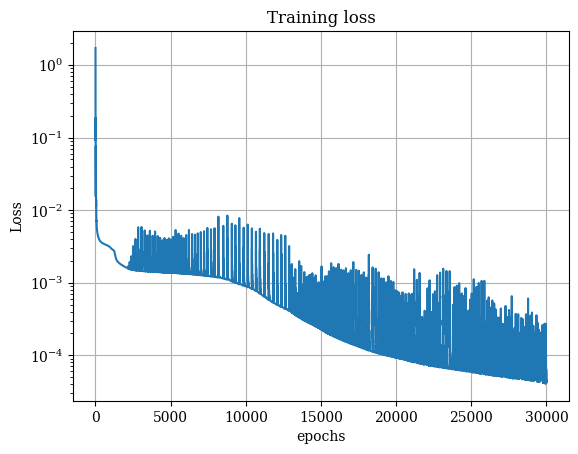

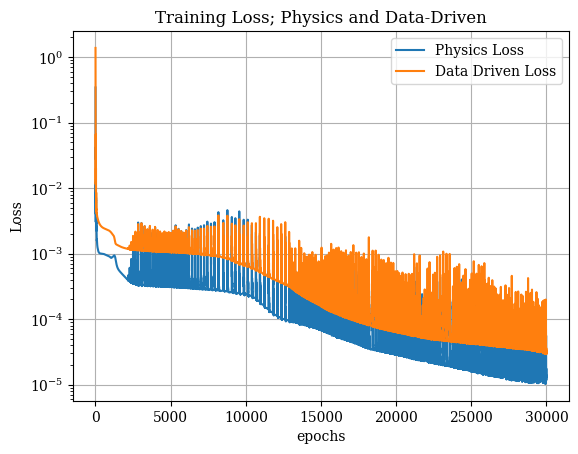

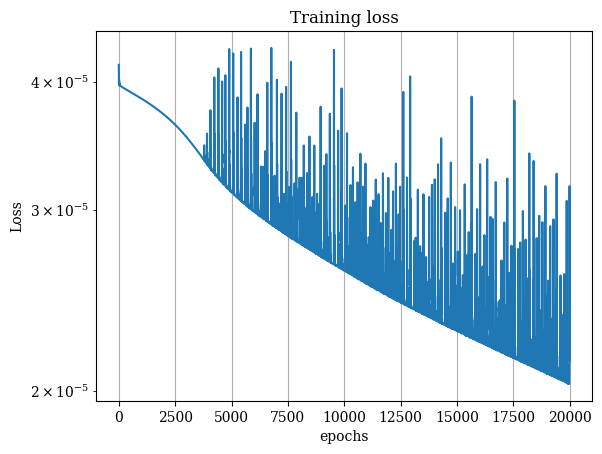

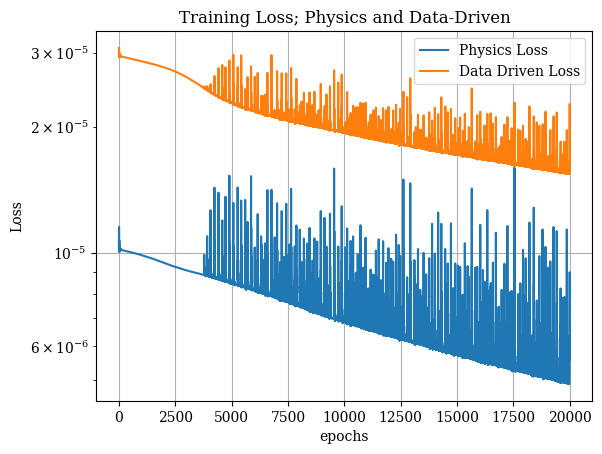

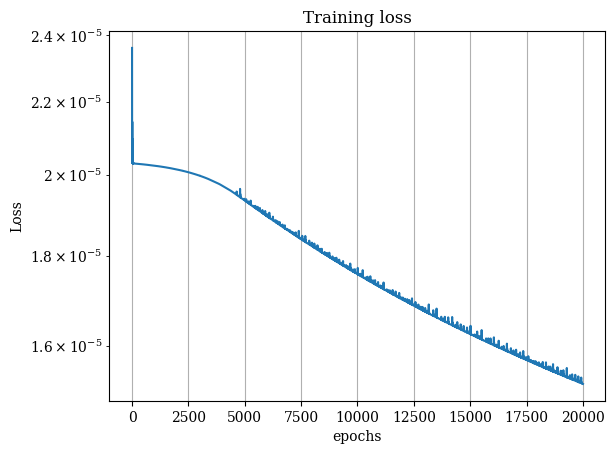

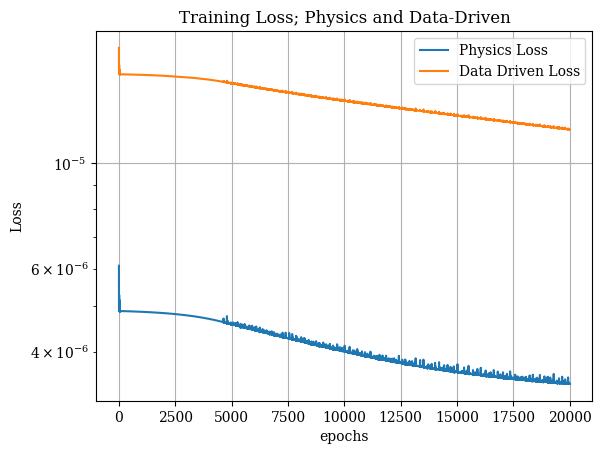

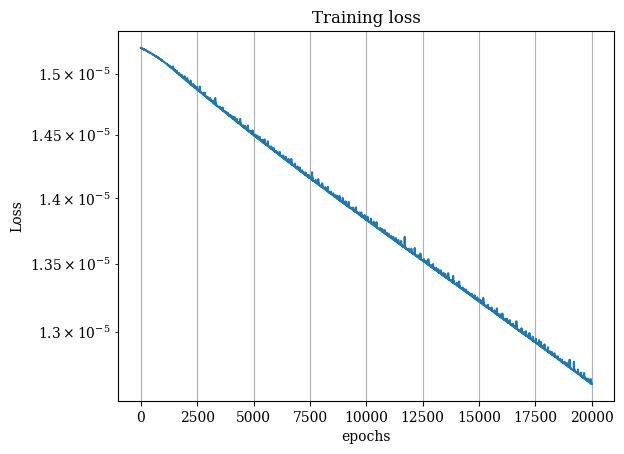

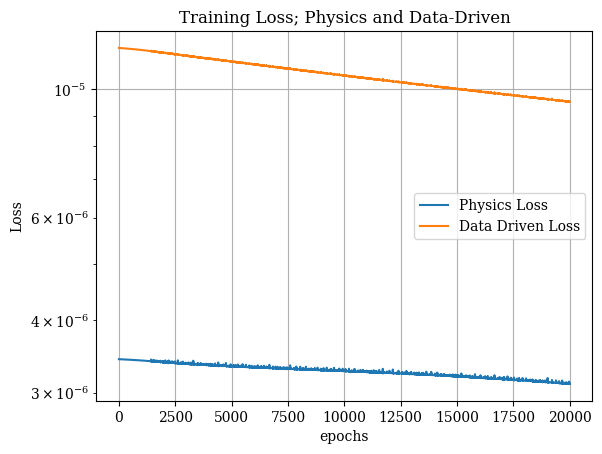

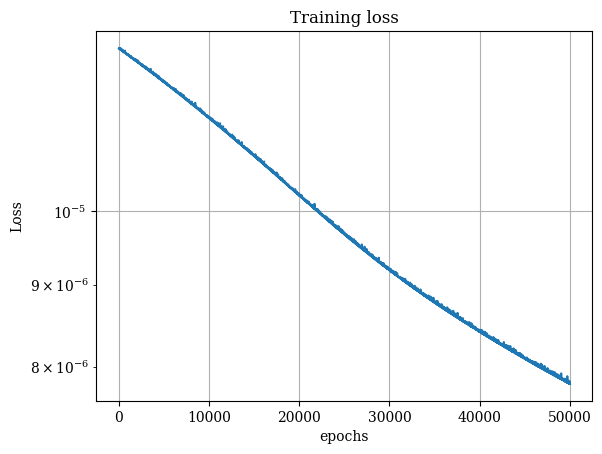

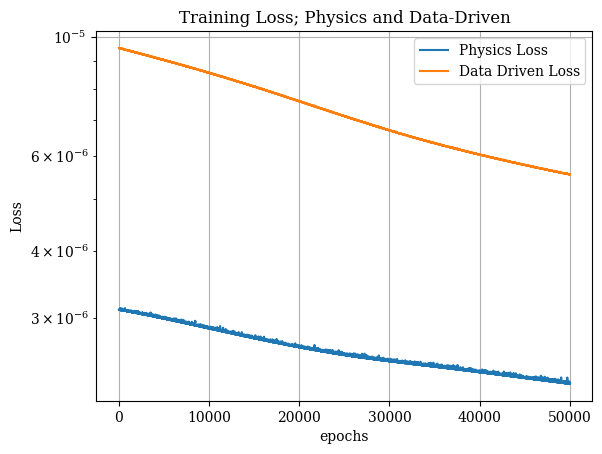

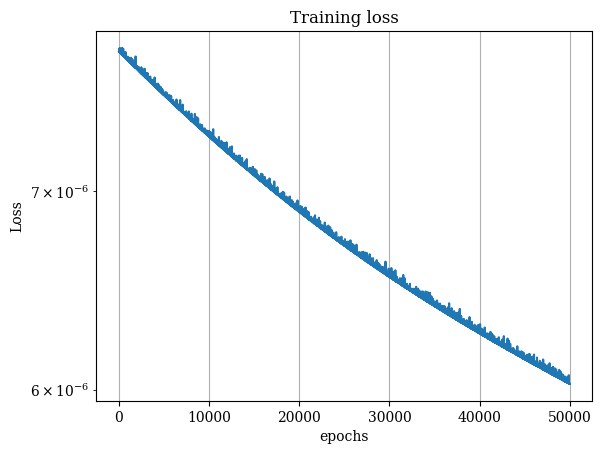

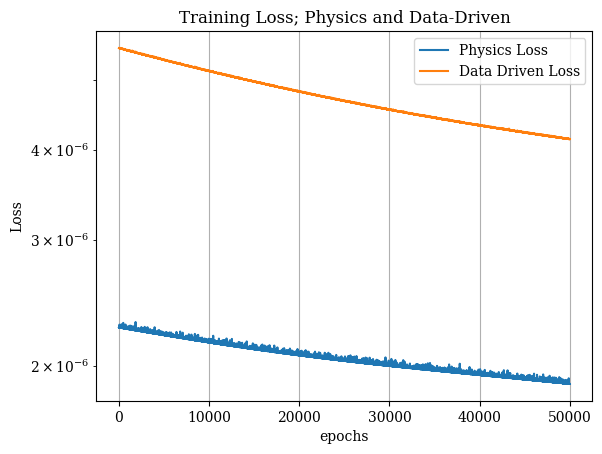

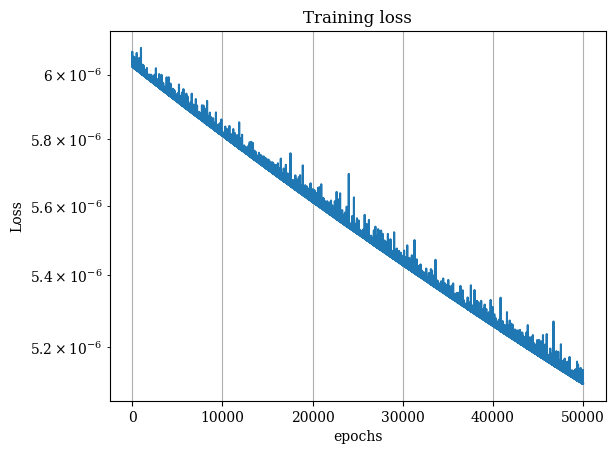

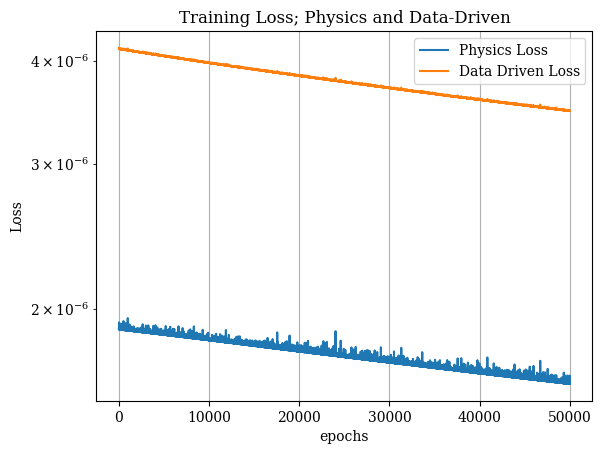

In [6]:
model.train(num_epochs=30000)

model.set_learning_rate(0.0001)
model.train(num_epochs=20000)

model.set_learning_rate(0.00001)
model.train(num_epochs=20000)

model.set_learning_rate(0.000005)
model.train(num_epochs=20000)

model.set_learning_rate(0.000005)
model.train(num_epochs=50000)

model.set_learning_rate(0.000005)
model.train(num_epochs=50000)

model.set_learning_rate(0.000005)
model.train(num_epochs=50000)

In [8]:
u_pred = model.predict(x.reshape(-1,1), t.reshape(-1,1)).reshape(-1, 1)
print("TEST MSE: ", np.mean(np.square(u_pred-U)))

TEST MSE:  0.11056857044567538


/var/folders/0h/w_d_nbpn21v3wpdv3l048nm80000gn/T/ipykernel_48616/3693431178.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.95])


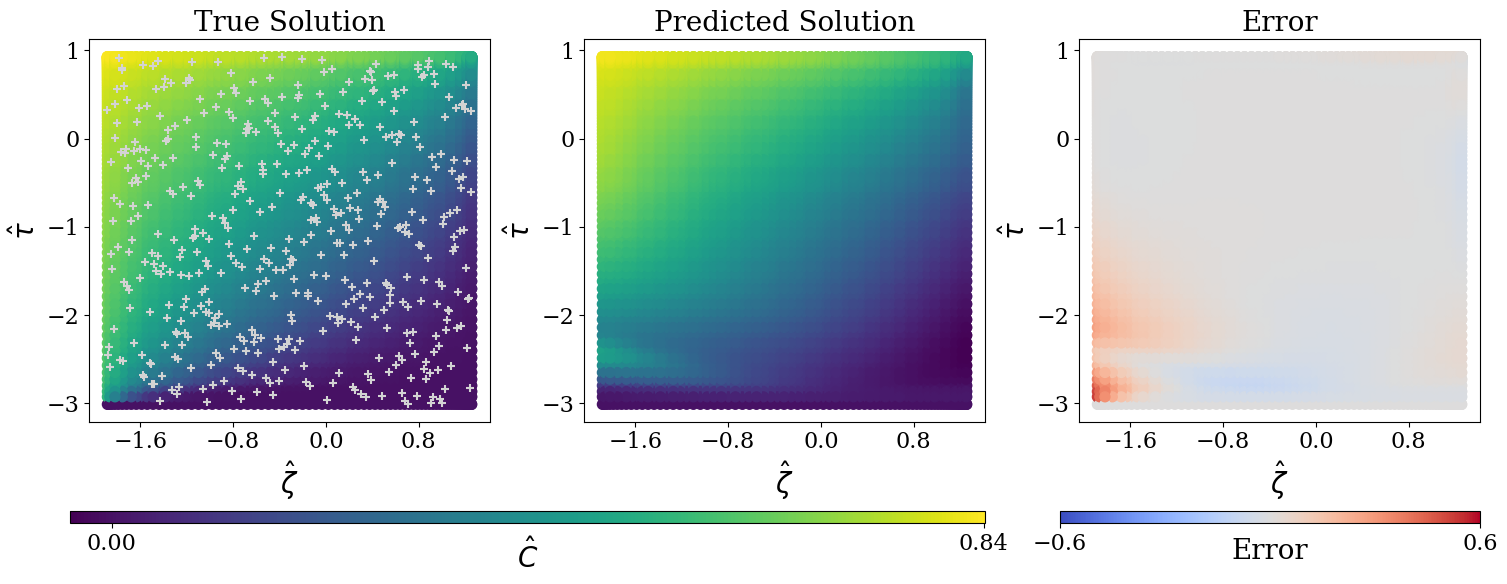

In [9]:
from matplotlib.ticker import MaxNLocator

# Determine common color limits
vmin = min(U.min(), u_pred[:,0].min())
vmax = max(U.max(), u_pred[:,0].max())

plt.rc('xtick', labelsize=16); 
plt.rc('ytick', labelsize=16);
plt.rc('axes', labelsize=20, titlesize=20); 
plt.rc('figure', titlesize=20); 


# Plot settings
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# True Solution
sc1 = axs[0].scatter(x, t, c=U, cmap='viridis', vmin=vmin, vmax=vmax, s=50)
axs[0].set_title('True Solution')
axs[0].set_xlabel(r"$\hat{\zeta}$")
axs[0].set_ylabel(r"$\hat{\tau}$")


# Colocation Points
sc11 = axs[0].scatter(model.x_c.clone().detach().cpu().numpy(),
                      model.t_c.clone().detach().cpu().numpy(),
                      color="lightgray", marker="+", zorder=100, s=35)

# Set fewer x and y ticks
axs[0].xaxis.set_major_locator(MaxNLocator(5))  
axs[0].yaxis.set_major_locator(MaxNLocator(5))  


# Predicted Solution
sc2 = axs[1].scatter(x, t, c=u_pred, cmap='viridis', vmin=vmin, vmax=vmax, s=50)
axs[1].set_title('Predicted Solution')
axs[1].set_xlabel(r"$\hat{\zeta}$")
axs[1].set_ylabel(r"$\hat{\tau}$")
# Set fewer x and y ticks
axs[1].xaxis.set_major_locator(MaxNLocator(5))  
axs[1].yaxis.set_major_locator(MaxNLocator(5))  

# Error Plot
from matplotlib.colors import LinearSegmentedColormap

colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # Blue -> White -> Red
nodes = [0.0, 0.5, 1.0] 
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, colors)))


error = U - u_pred[:,0]
sc3 = axs[2].scatter(x, t, c=error, cmap="coolwarm", vmin=-0.6, vmax=0.6, s=50)
# Set fewer x and y ticks
axs[2].xaxis.set_major_locator(MaxNLocator(5))  
axs[2].yaxis.set_major_locator(MaxNLocator(5))  
axs[2].set_title('Error')
axs[2].set_xlabel(r"$\hat{\zeta}$")
axs[2].set_ylabel(r"$\hat{\tau}$")

from mpl_toolkits.axes_grid1 import make_axes_locatable


# Create shared colorbar for the first two plots
cbar_ax = fig.add_axes([0.05, 0.07, 0.61, 0.02])  
cbar = fig.colorbar(sc1, cax=cbar_ax, orientation='horizontal')
cbar.ax.xaxis.set_label_position('bottom')
cbar.set_label(r"$\hat{C}$", labelpad=-12)
cbar.set_ticks([0, 0.84])

# Create colorbar for the third plot
cbar_ax3 = fig.add_axes([0.71, 0.07, 0.28, 0.02])  
cbar3 = fig.colorbar(sc3, cax=cbar_ax3, orientation='horizontal')
cbar3.set_label('Error', labelpad=-12)
cbar3.set_ticks([-0.6, 0.6])

plt.tight_layout(rect=[0, 0.08, 1, 0.95])

plt.show()
fig.savefig(f"./Figures/hp_pipe_error.pdf", dpi=300, format='pdf')


In [10]:
datapath = f"./Data/"

np.save(datapath+"U.npy", U)
np.save(datapath+"u_pred.npy", u_pred)
np.save(datapath+"x.npy", x)
np.save(datapath+"t.npy", t)
np.save(datapath+"x_c.npy", model.x_c.clone().detach().cpu().numpy())
np.save(datapath+"t_c.npy", model.t_c.clone().detach().cpu().numpy())

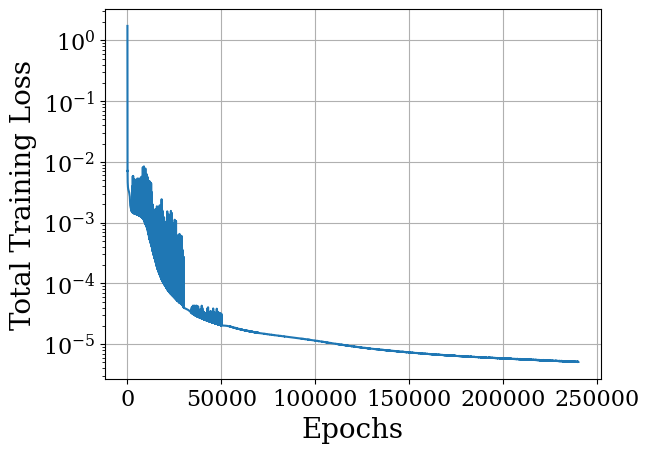

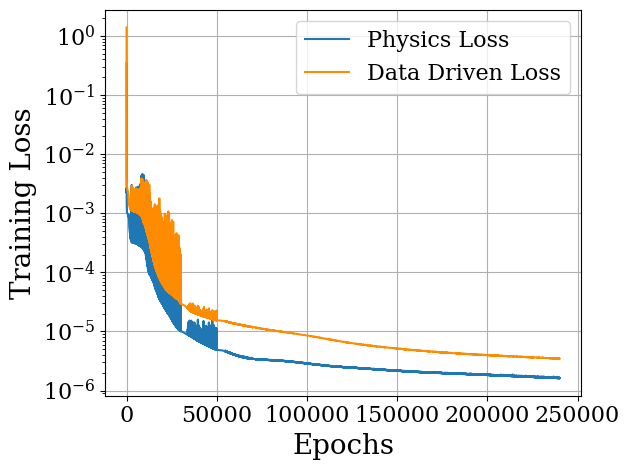

In [11]:

grid = True


plt.figure()
plt.semilogy(np.arange(1, len(model.losslist)+1), model.losslist)
plt.xlabel('Epochs')
plt.ylabel('Total Training Loss')
plt.grid(grid)
plt.savefig(f"./Figures/hp_pipe_total_training.pdf", dpi=300, format='pdf')

np.savetxt(f"./Figures/hp_phy_loss", model.phy_loss)
np.savetxt(f"./Figures/hp_data_loss", model.data_loss)


plt.figure()
plt.semilogy(np.arange(1, len(model.losslist)+1), model.phy_loss, label='Physics Loss')
plt.semilogy(np.arange(1, len(model.losslist)+1), model.data_loss, label='Data Driven Loss', color="darkorange")
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend(fontsize=16)
plt.grid(grid)
plt.tight_layout()
plt.savefig(f"./Figures/hp_pipe_separate_training.pdf", dpi=300, format='pdf')


0.8411026543586817


/var/folders/0h/w_d_nbpn21v3wpdv3l048nm80000gn/T/ipykernel_48616/2249303550.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.96])  # Adjust layout to fit the colorbar and avoid overlap


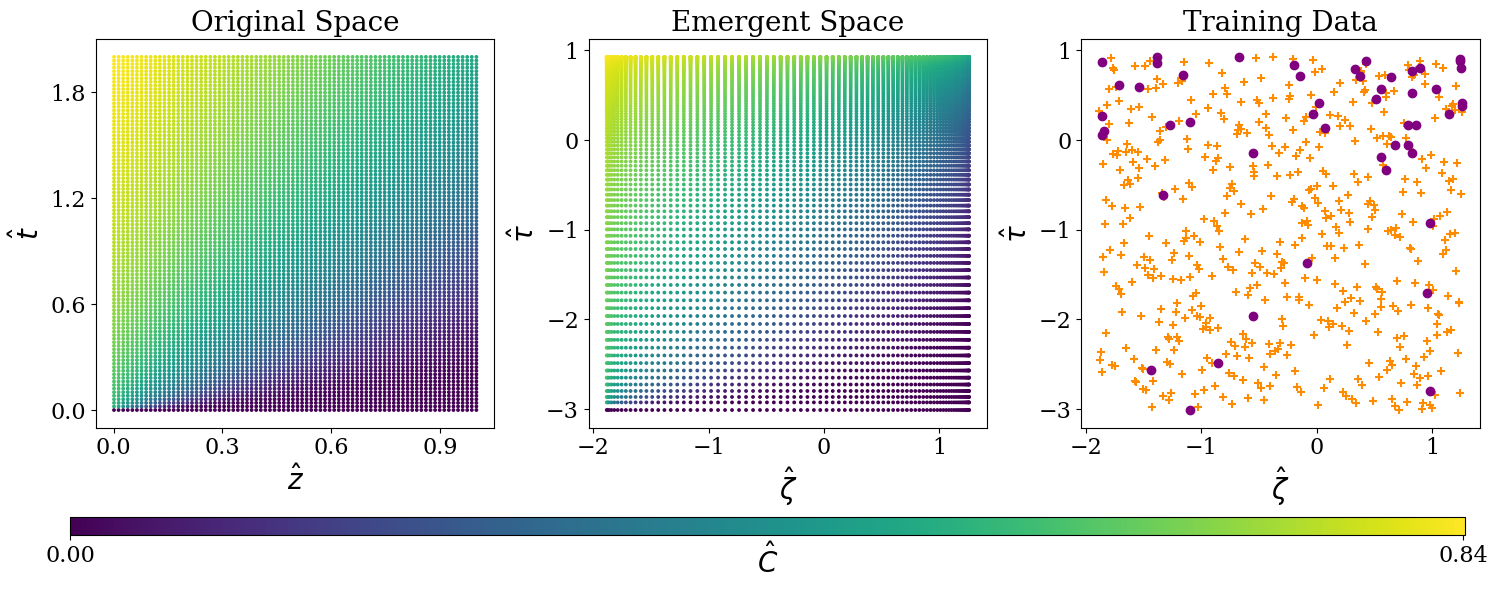

In [12]:
TIME = 2 # minutes
LENGTH = 1 # meters

NT = 100
NL = 80

## original data
FOLDER = "../Diffusion_Convection/1_80_100/"
original = scipy.io.loadmat(f"{FOLDER}2dpipe_Peclet2_original.mat")["Data"]

time = np.linspace(0,TIME,NT)
space = np.linspace(0.001,LENGTH,NL)

x_or = np.zeros(len(space)*len(time))
t_or = np.zeros(len(space)*len(time))
U_or_2D = np.zeros(len(space)*len(time))

count = 0
for i, x_orr in enumerate(space):
	for j, t_orr in enumerate(time):
		U_or_2D[count] = original[i, j]
		x_or[count] = x_orr
		t_or[count] = t_orr
		count +=1

fig, axes = plt.subplots(1, 3, figsize=(15,6))

# Plot one scatter plot
sc1 = axes[0].scatter(x_or, t_or, c=U_or_2D, cmap='viridis', s=3)
axes[0].set_xlabel(r"$\hat{z}$")
axes[0].set_ylabel(r"$\hat{t}$")
axes[0].set_title("Original Space")
axes[0].xaxis.set_major_locator(MaxNLocator(4))  
axes[0].yaxis.set_major_locator(MaxNLocator(4))  

# Plot second scatter plot
sc2 = axes[1].scatter(x, t, c=U, cmap='viridis', s=3)
axes[1].set_xlabel(r"$\hat{\zeta}$")
axes[1].set_ylabel(r"$\hat{\tau}$")
axes[1].set_title("Emergent Space")
axes[1].xaxis.set_major_locator(MaxNLocator(4))  
axes[1].yaxis.set_major_locator(MaxNLocator(5))  


# Plot third scatter plot
sc3 = axes[2].scatter(model.x.clone().detach().cpu().numpy(),
            		  model.t.clone().detach().cpu().numpy(),
					 zorder=1000, color="purple")
axes[2].scatter(model.x_c.clone().detach().cpu().numpy(),
            	model.t_c.clone().detach().cpu().numpy(), color="darkorange", marker="+", zorder=100)
axes[2].set_xlabel(r"$\hat{\zeta}$")
axes[2].set_ylabel(r"$\hat{\tau}$")
axes[2].set_title("Training Data")
axes[2].xaxis.set_major_locator(MaxNLocator(4))  # Set max 5 x-ticks
axes[2].yaxis.set_major_locator(MaxNLocator(5))  # Set max 5 y-ticks

# Create an axis for the colorbar that spans the entire figure width
cbar_ax = fig.add_axes([0.05, 0.06, 0.93, 0.03])
cbar = fig.colorbar(sc1, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r"$\hat{C}$", labelpad=-17)
cbar.set_ticks([0, 0.84])

print(max(U_or_2D))

plt.tight_layout(rect=[0, 0.08, 1, 0.96])  # Adjust layout to fit the colorbar and avoid overlap

plt.savefig(f"./Figures/hp_input_orgvsemb.pdf", dpi=300, format='pdf')
plt.show()